# Purpose

The purpose of this notebook is to create figures on adoption targeting. The ones we are going for are:

1. Plotting of flows for priority routes TO/FROM the metro. 

The idea we'll pursue is this: for most routes, changing to the metro would reduce overall congestion on the street layer. However, there are some routes for which changing to the metro could have a potentially large NEGATIVE impact on overall congestion. If we'd like these folks to use the metro, then we should put buses there. 

In [1]:
import matplotlib
matplotlib.use('Agg')

% matplotlib inline

# homebrewed modules
from metro import multiplex as mx
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data
from metro import ita

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import random                   # randomly sample node subsets
import matplotlib.pyplot as plt # convenience for plotting
import seaborn as sns           # main plotting library
from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import igraph
import pandas as pd

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
warnings.filterwarnings('ignore') # stops ipython from printing warnings
sns.set_style("white") # nicer background style

In [6]:
multi = mx.read_multi(nodes_file_name = '3_throughput/mx_flow_nodes.txt', 
                      edges_file_name = '3_throughput/mx_flow_edges.txt')

multi.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

In [7]:
df = pd.read_csv('3_throughput/route_info_100.csv')

In [8]:
g, od = multi.to_igraph()

In [9]:
ita.compute_gradient('free_flow_time_m', 'flow_100', 'capacity', .15, 4, g.es)

def metro_gradients(g, weight, direction):
    def path_length(path, weight):
        return np.sum(g.es[e][weight] for e in path)

    taz = g.vs.select(lambda v: v['layer'] == 'taz')
    metro = g.vs.select(lambda v: v['layer'] == 'metro')
    
    def nearest_gradient(s, weight, direction):
        paths = g.get_shortest_paths(s, 
                                     to = metro,
                                     weights = weight, 
                                     mode = direction,
                                     output = 'epath')

        path_lengths = np.array([path_length(path, weight) for path in paths])
        min_path = paths[np.argmin(path_lengths)]
        gradient = np.sum([g.es[e]['gradient'] for e in min_path])
        return gradient
    
    return {int(s['con_name']) : nearest_gradient(s, weight, direction) for s in taz}

In [25]:
to_metro_gradients = metro_gradients(g, 'congested_time_m_100', 'OUT')
from_metro_gradients = metro_gradients(g, 'congested_time_m_100', 'IN')

In [26]:
df['to_metro_gradient'] = df.d_con.map(to_metro_gradients.get)
df['from_metro_gradient'] = df.o_con.map(from_metro_gradients.get)

In [27]:
df['net_gradient'] = df.gradient - df.to_metro_gradient - df.from_metro_gradient

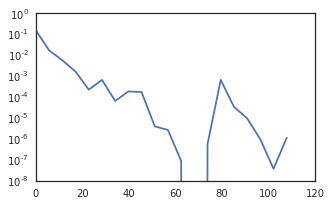

In [28]:
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
viz.weighted_hist(ax = ax,
                  measure = df.to_metro_gradient + df.from_metro_gradient,
                  weights = df.flow, 
                  label = 'hist',
                  n = 20)
ax.set_yscale('log')


[(0, 200.0)]

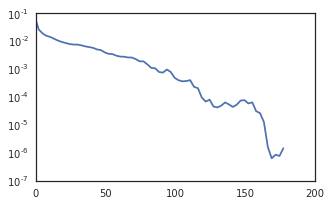

In [29]:
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
viz.weighted_hist(ax = ax,
                  measure = df.net_gradient,
                  weights = df.flow, 
                  label = 'hist',
                  n = 100)
ax.set_yscale('log')
ax.set(xlim = (0,None))

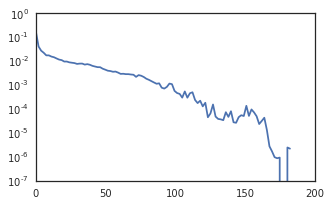

In [30]:
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
viz.weighted_hist(ax = ax,
                  measure = df.gradient,
                  weights = df.flow, 
                  label = 'hist',
                  n = 100)
ax.set_yscale('log')

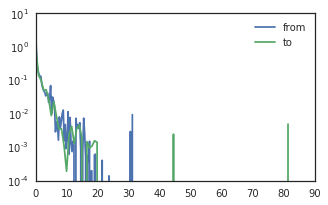

In [44]:
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
viz.weighted_hist(ax = ax,
                  measure = df.from_metro_gradient,
                  weights = df.flow, 
                  label = 'from',
                  n = 100)
viz.weighted_hist(ax = ax,
                  measure = df.to_metro_gradient,
                  weights = df.flow, 
                  label = 'to',
                  n = 100)
ax.legend()
ax.set_yscale('log')

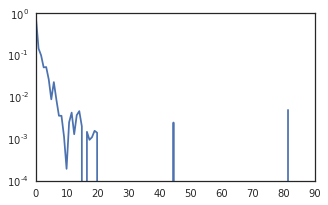

In [41]:
fig = plt.figure(figsize = (5,3))
ax = fig.add_subplot(111)
viz.weighted_hist(ax = ax,
                  measure = df.to_metro_gradient,
                  weights = df.flow, 
                  label = 'hist',
                  n = 100)
ax.set_yscale('log')

In [33]:
def wavg_constructor(col, weights):    
    def wavg(group):
        d = group[col]
        w = group[weights]
        return (d * w).sum() / w.sum()
    return wavg

In [34]:
con_map = {int(multi.G.node[n]['con_name']) : n for n in multi.G.node if multi.G.node[n]['layer'] == 'taz'}

In [94]:
cols = ['gradient', 'to_metro_gradient']
cols = {'o_' + col : df.groupby('o_con').apply(wavg_constructor(col, 'flow')) for col in cols}
flow = {'o_flow' : df.groupby('o_con').flow.sum()}
cols.update(flow)
o = pd.DataFrame(cols)
o['node'] = o.index.map(con_map.get)
o['to_metro_flow_cut'] = (o.o_to_metro_gradient > 2.5) * o.o_flow
d = o.set_index('node').to_dict()

for key in d:
    nx.set_node_attributes(multi.G, key, 0)
    nx.set_node_attributes(multi.G, key, d[key])

In [95]:
cols = ['gradient', 'from_metro_gradient']
cols = {'d_' + col : df.groupby('d_con').apply(wavg_constructor(col, 'flow')) for col in cols}
flow = {'d_flow' : df.groupby('d_con').flow.sum()}
cols.update(flow)
d = pd.DataFrame(cols)
d['node'] = d.index.map(con_map.get)
d['from_metro_flow_cut'] = (d.d_from_metro_gradient > 2.5) * d.d_flow
d = d.set_index('node').to_dict()

for key in d:
    nx.set_node_attributes(multi.G, key, 0)
    nx.set_node_attributes(multi.G, key, d[key])

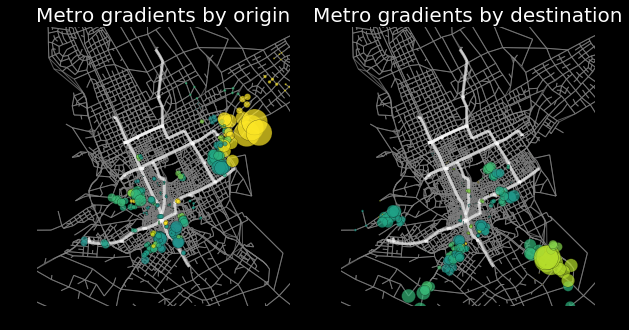

In [100]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

viz.bubble_plot(multi.G, 
                size = 'to_metro_flow_cut', 
                color = 'o_to_metro_gradient', 
                size_factor = .3, 
                cmap = 'viridis',
                vmax = 5,
                alpha = .7,
                ax = ax1)

if multi.check_layer('metro'):
      G = multi.layers_as_subgraph(['metro'])
      nx.draw_networkx_edges(G, viz.get_coords(G),
              edge_color = 'white', 
              width = 3,
              node_color = 'white',
              node_size = 0,
              alpha = .4,
              with_labels = False,
              arrows = False,
              ax = ax1)

viz.bubble_plot(multi.G, 
                size = 'from_metro_flow_cut', 
                color = 'd_from_metro_gradient', 
                size_factor = .3, 
                cmap = 'viridis',
                vmax = 5,
                alpha = .7,
                ax = ax2)

if multi.check_layer('metro'):
      G = multi.layers_as_subgraph(['metro'])
      nx.draw_networkx_edges(G, viz.get_coords(G),
              edge_color = 'white', 
              width = 3,
              node_color = 'white',
              node_size = 0,
              alpha = .4,
              with_labels = False,
              arrows = False,
              ax = ax2)

center_point = (46.7167, 24.6833)
l = .27

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

ax1.set(xlim = xlim, ylim = ylim)
ax1.set_title(r'Metro gradients by origin', 
              color = 'w', 
              fontsize = 20)

ax2.set(xlim = xlim, ylim = ylim)
ax2.set_title(r'Metro gradients by destination', 
              color = 'w', 
              fontsize = 20)

fig.set_facecolor("#000000")
pylab.rcParams['savefig.facecolor'] = 'black'
plt.savefig('4_figs/metro_gradients.png')